# DTSA-5511 Week 5 - I’m Something of a Painter Myself

A Jupyter notebook with a description of the problem/data, exploratory data analysis (EDA) procedure, analysis (model building and training), result, and discussion/conclusion.

## Project description
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

## Dataset Description
The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

The monet directories contain Monet paintings. 

The photo directories contain photos. 

### Files
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format

## 1. Exploratory Data Analysis (EDA)

### 1.1. Importing libraries
Loading libraries required for this mini-project.

In [1]:
#utilities
import numpy as np
import random
import re
import pandas as pd
import PIL

#plots
import matplotlib.pyplot as plt

# modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# detect TPU device
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

# dynamically tune value at runtime
AUTOTUNE = tf.data.experimental.AUTOTUNE

# tensorflow version
print(tf.__version__)

2022-10-02 02:36:40.155299: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-02 02:36:40.155366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-10-02 02:36:41.942043: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-02 02:36:41.942345: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-02 02:36:41.942367: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-02 02:36:41.942390: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c97d3990c257): /proc/driver/nvidia/version does not exist
2022-10-02 02:36:41.943031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


### 1.2. TFRecords
Reading the photo and Monet images on the TFRecords files and creating functions for loading those images.

In [2]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 16

# Load the data
gcs_path = KaggleDatasets().get_gcs_path()

monet_files = tf.io.gfile.glob(str(gcs_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_files))

photo_files = tf.io.gfile.glob(str(gcs_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_files))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-10-02 02:37:09.354122: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-02 02:37:09.423265: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [3]:
# Function to count the number of photo and Monet images
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(monet_files)
n_photo_samples = count_data_items(photo_files)

In [4]:
# Function to decode a JPEG-encoded image to an RGB channel
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Function to parse a simple example photo to decode the image
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Function to extract image from files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

### 1.3. Image visualization
Visualizing three samples of photo and Monet images.

In [5]:
# Loading the Monet images
monet_ds = load_dataset(monet_files, labeled=True).batch(10)
# Loading the photo images
photo_ds = load_dataset(photo_files, labeled=True).batch(10)

In [6]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

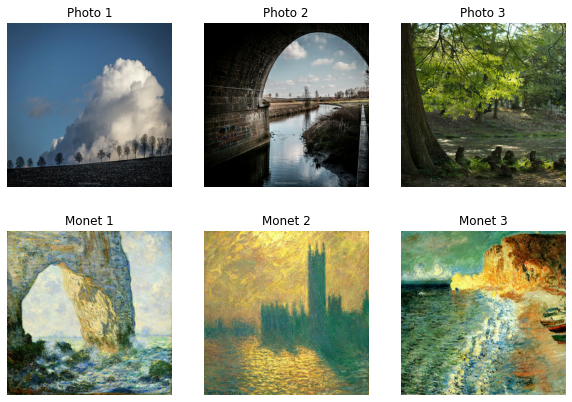

In [7]:
#number = random.randint(0, 9)
plt.figure(figsize=(10, 7))

plt.subplot(231)
plt.title('Photo 1')
plt.axis('off')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.subplot(232)
plt.axis('off')
plt.title('Photo 2')
plt.imshow(example_photo[1] * 0.5 + 0.5)
plt.subplot(233)
plt.axis('off')
plt.title('Photo 3')
plt.imshow(example_photo[2] * 0.5 + 0.5)

plt.subplot(234)
plt.title('Monet 1')
plt.axis('off')
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.subplot(235)
plt.title('Monet 2')
plt.axis('off')
plt.imshow(example_monet[1] * 0.5 + 0.5)
plt.subplot(236)
plt.title('Monet 3')
plt.axis('off')
plt.imshow(example_monet[2] * 0.5 + 0.5)

## 2. CycleGAN 
Implementing CycleGAN because it is a very popular GAN architecture used to learn transformation between images of different styles.

### 2.1. Building RestNet architecture
This architecture introduces the concept of Residual Blocks to solve the problem of vanishing/exploring gradient. 

In [8]:
OUTPUT_CHANNELS = 3

# Reducing the features of an array or an image. 
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

# Inserting null-values between original values to increase the sampling rate
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

# Generating ResNet
def ResNetGenerator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [9]:
#Building the ResNet and printing the model summary
generator = ResNetGenerator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  524800      sequential_1[0][0]               
______________________________________________________________________________________________

### 2.2. Building the discriminator
The discriminator is used to distinguish real data from the data created by the generator. 

In [10]:
# Function to create the discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
# Generating the discriminator
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_15 (Sequential)   (None, 128, 128, 64)      3072      
_________________________________________________________________
sequential_16 (Sequential)   (None, 64, 64, 128)       131328    
_________________________________________________________________
sequential_17 (Sequential)   (None, 32, 32, 256)       524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 512)       2097152   
_________________________________________________________________
instance_normalization_16 (I (None, 31, 31, 512)       1024

In [12]:
with strategy.scope():
    monet_generator = ResNetGenerator() # transforms photos to Monet-esque paintings
    photo_generator = ResNetGenerator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

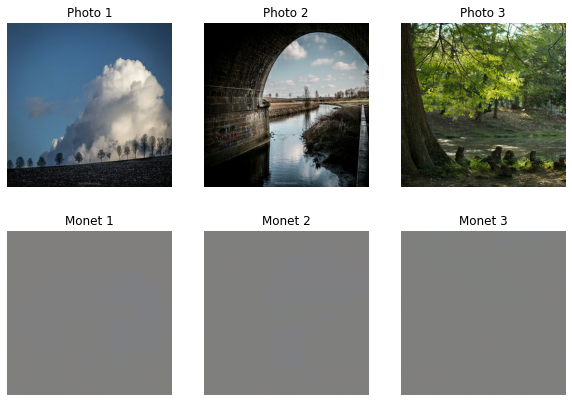

In [13]:
# Visualization 
plt.figure(figsize=(10, 7))
to_monet = monet_generator(example_photo)

plt.subplot(231)
plt.title('Photo 1')
plt.axis('off')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.subplot(232)
plt.axis('off')
plt.title('Photo 2')
plt.imshow(example_photo[1] * 0.5 + 0.5)
plt.subplot(233)
plt.axis('off')
plt.title('Photo 3')
plt.imshow(example_photo[2] * 0.5 + 0.5)

plt.subplot(234)
plt.title('Monet 1')
plt.axis('off')
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.subplot(235)
plt.title('Monet 2')
plt.axis('off')
plt.imshow(to_monet[1] * 0.5 + 0.5)
plt.subplot(236)
plt.title('Monet 3')
plt.axis('off')
plt.imshow(to_monet[2] * 0.5 + 0.5)

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

### 2.3. Building the cGAN model
Overriding the train_step() method of the Model class for training via fit().

In [14]:
# CycleGan class
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# 3. Training
Fitting the best weights and biases to CGAN model to minimize the loss function over prediction range

In [15]:
with strategy.scope():
    # Returns the gradients of the loss with respect to the learnable parameters in the networks and an array of generated images.
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
with strategy.scope():
    # Goes through the discriminator and gets classified as either “Real” or “Fake” based on the ability of the discriminator to tell one from the other.
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    # Calculate the cycle consistency loss be finding the average of their difference.
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1    
    
with strategy.scope():
    # Compares the input with the output of the generator.
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss    

In [16]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [17]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# 4. Prediction and Submission
Generating the Monet images and submitting the images.

In [18]:
# Train the model for 50 epochs.
history1 = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100
).history

Epoch 1/100
30/30 [==============================] - 110s 127ms/step - monet_gen_loss: 10.2396 - photo_gen_loss: 10.7708 - monet_disc_loss: 0.6603 - photo_disc_loss: 0.6552
Epoch 2/100
 1/30 [>.............................] - ETA: 4s - monet_gen_loss: 6.5794 - photo_gen_loss: 6.5716 - monet_disc_loss: 0.6514 - photo_disc_loss: 0.6085

2022-10-02 02:40:10.686212: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 11295, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1664678410.682832454","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 11295, Output num: 0","grpc_status":3}


30/30 [==============================] - 4s 126ms/step - monet_gen_loss: 5.4800 - photo_gen_loss: 5.7299 - monet_disc_loss: 0.5964 - photo_disc_loss: 0.5785
Epoch 3/100
30/30 [==============================] - 4s 126ms/step - monet_gen_loss: 5.2647 - photo_gen_loss: 5.5166 - monet_disc_loss: 0.5418 - photo_disc_loss: 0.5032
Epoch 4/100
30/30 [==============================] - 4s 127ms/step - monet_gen_loss: 4.9640 - photo_gen_loss: 5.2243 - monet_disc_loss: 0.6414 - photo_disc_loss: 0.5540
Epoch 5/100
30/30 [==============================] - 4s 127ms/step - monet_gen_loss: 4.7816 - photo_gen_loss: 4.9205 - monet_disc_loss: 0.5443 - photo_disc_loss: 0.5323
Epoch 6/100
30/30 [==============================] - 4s 126ms/step - monet_gen_loss: 4.5648 - photo_gen_loss: 4.8819 - monet_disc_loss: 0.5883 - photo_disc_loss: 0.4048
Epoch 7/100
30/30 [==============================] - 4s 126ms/step - monet_gen_loss: 4.2725 - photo_gen_loss: 4.7553 - monet_disc_loss: 0.6147 - photo_disc_loss: 0.344

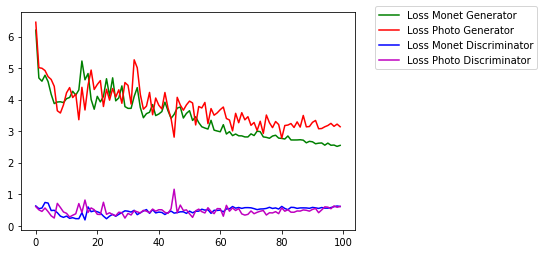

In [20]:
# Chart to display the loss generator and loss discriminator for photo and Monet images.
loss_results_df = pd.DataFrame(history1)
loss_results_df = loss_results_df.applymap(np.mean)

plt.plot(loss_results_df.index, loss_results_df['monet_gen_loss'], color='g', label='Loss Monet Generator')
plt.plot(loss_results_df.index, loss_results_df['photo_gen_loss'], color='r', label='Loss Photo Generator')
plt.plot(loss_results_df.index, loss_results_df['monet_disc_loss'], color='b', label='Loss Monet Discriminator')
plt.plot(loss_results_df.index, loss_results_df['photo_disc_loss'], color='m', label='Loss Photo Discriminator')
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1.05))
plt.show()

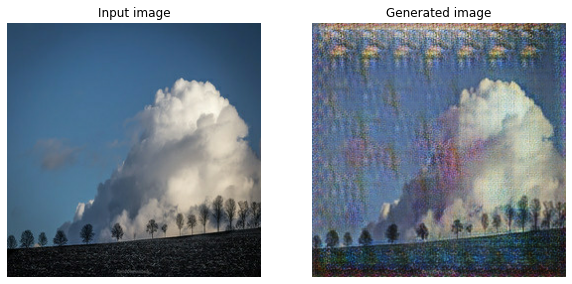

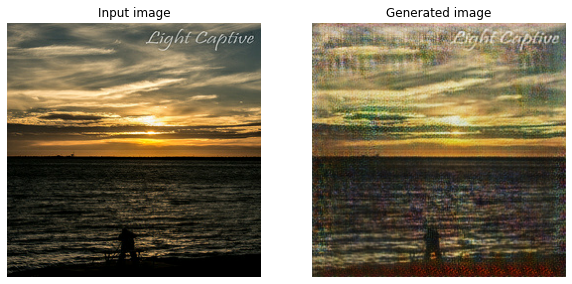

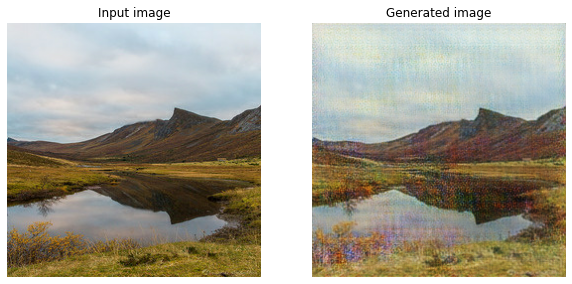

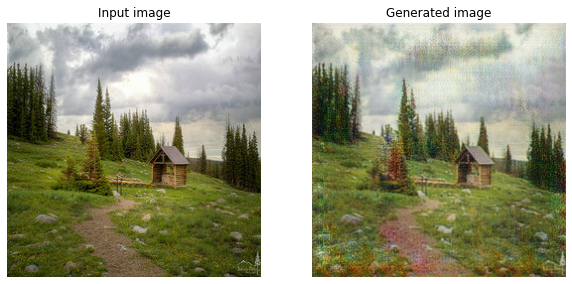

In [24]:
ds_iter = iter(photo_ds)
for n_sample in range(4):
        example_sample = next(ds_iter)
        generated_sample = monet_generator(example_sample)
        
        f = plt.figure(figsize=(10, 10))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [25]:
! mkdir ../images

In [26]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2022-10-02 02:55:03.756071: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 526912, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1664679303.755997879","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 526912, Output num: 0","grpc_status":3}


In [27]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# 5. Discussion
## 5.1. Conclusion
By increasing the epochs numbers during the training, the generation of images looked more like Monet images. Thus, I selected 100 from values between 30 to 100.

## 5.2. Further improvement
For further improvement, I would like to add Differentiable Augmentation (DiffAugment). It enables the gradients to be propagated through the augmentation back to the generator, regularizes the discriminator without manipulating the target distribution, and maintains the balance of training dynamics. Three choices of transformation I would like to experiments which are translation, cutOut, and color.